In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# OT-Flow

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from jax import config
config.update("jax_enable_x64", True)

In [3]:
import OTF, CNF, RealNVP, DatasetGenerator
import numpy as np
import pandas as pd
import optax
import matplotlib.pyplot as plt

from jax import jit, grad, value_and_grad, random
from flax.training import checkpoints

# plotting, move this to seperate notebook
from jax import vmap
import jax.numpy as jnp
from matplotlib import colormaps

2024-05-06 15:16:08.917152: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
PRECISION_PREFIX = 'float64'

In [5]:
key = random.PRNGKey(seed=42)

In [6]:
training_size = 10000
validation_size = 10000
test_size = 20000

In [7]:
BATCH_SIZE_TR = training_size
BATCH_SIZE_VAL_TE = validation_size

In [8]:
train, val, test = DatasetGenerator.make_tuc_logo(
    key, 
    training_size, 
    validation_size, 
    test_size, 
    dtype=PRECISION_PREFIX,
)
normal_sample = random.normal(random.fold_in(key, 42), shape=(validation_size, 2), dtype=PRECISION_PREFIX)

In [9]:
MODEL = OTF.OTF(
        input_dim=2, 
        hidden_dim=64,
        resnet_depth=2,
        rank=20,
        key=key, 
        phi=OTF.Phi,
        alpha1=15.,
        alpha2=2.,
        num_blocks=3,
        t0=0.,
        t1=1.,
        num_steps=20
)
LOSS_FUNC = jit(MODEL._loss)
VAL_LOSS_FUNC = jit(MODEL.metrics)
LOSS_KWARGS = {}
VAL_LOSS_KWARGS = {'normal_batch': normal_sample}

In [10]:
EVAL_SOLVER_STEPS = 40

In [11]:
def eval_val(val_data, params, solver_steps):
    return VAL_LOSS_FUNC(params=params, batch=val_data, **VAL_LOSS_KWARGS, solver_steps=solver_steps)

In [12]:
middle = 'OFT_float64_tuc-logo_3pot'

In [13]:
params = checkpoints.restore_checkpoint('checkpoints/finalfinal/' + middle + '_params/checkpoint_20000/checkpoint', None)
best_params_loss = checkpoints.restore_checkpoint('checkpoints/finalfinal/' + middle + '_bestparams_loss/checkpoint_20000/checkpoint', None)
best_params_mmd = checkpoints.restore_checkpoint('checkpoints/finalfinal/' + middle + '.csv_bestparams_mmd/checkpoint_20000/checkpoint', None)

In [14]:
train_history = pd.read_csv('OFT_float64_tuc-logo_3pot.csv', sep=',', index_col=0)

## Plot History

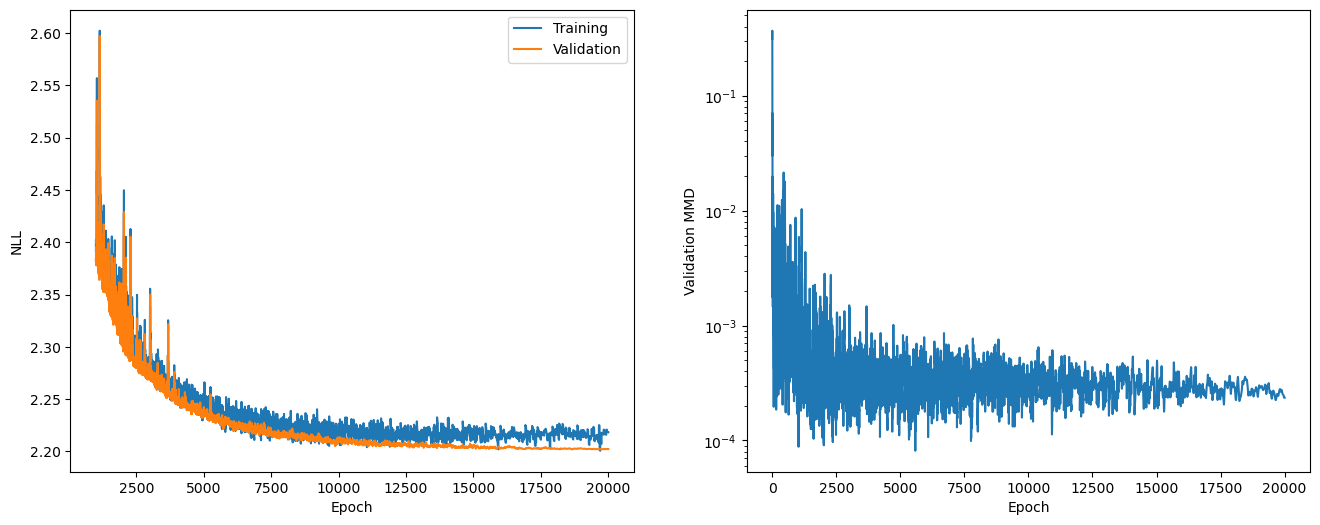

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(train_history['Epoch'][1000:], train_history['Training Loss'][1000:], label='Training')
ax[0].plot(train_history['Epoch'][1000:], train_history['Validation Loss'][1000:], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('NLL')
ax[0].legend()

ax[1].semilogy(train_history['Epoch'], train_history['Validation MMD'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation MMD');

## Test Metrics

In [16]:
best_epoch_mmd = train_history.loc[19999, 'Best Epoch MMD'].astype('int')
best_val_mmd = train_history.loc[19999, 'Best Validation MMD']

best_epoch_loss = train_history.loc[19999, 'Best Epoch Loss'].astype('int')
best_val_loss = train_history.loc[19999, 'Best Validation Loss']

In [17]:
print(f'\nBest Epoch MMD: {best_epoch_mmd} --- Val MMD: {best_val_mmd}')
test_loss, test_inv_error, test_mmd = eval_val(test, best_params_mmd, EVAL_SOLVER_STEPS)
print(f'Best Model MMD --- Test Loss: {test_loss}, Test Inv Error: {test_inv_error}, Test MMD: {test_mmd}')

print(f'\nBest Epoch Loss: {best_epoch_loss} --- Val Loss: {best_val_loss}')
test_loss, test_inv_error, test_mmd = eval_val(test, best_params_loss, EVAL_SOLVER_STEPS)
print(f'Best Model Loss --- Test Loss: {test_loss}, Test Inv Error: {test_inv_error}, Test MMD: {test_mmd}')


Best Epoch MMD: 2018 --- Val MMD: 9.445158662069186e-05
Best Model MMD --- Test Loss: 20.916179833607472, Test Inv Error: 7.847240215902061e-08, Test MMD: 0.30819963006068574

Best Epoch Loss: 19777 --- Val Loss: 2.201966998446151
Best Model Loss --- Test Loss: 2.204585271810174, Test Inv Error: 1.0015062505313816e-11, Test MMD: 0.00013221973562094202


## Model-specific Plots

In [18]:
sample = random.normal(key, shape=(2000,2))
sample_colors = random.normal(key, shape=(20,2))

cmap = colormaps['tab20']  #('hsv') #('nipy_spectral')
max_colors = 20
colors = [cmap(color_number / max_colors) for color_number in range(max_colors)]

In [19]:
offset = 0.3
plt_params = {
    'X_MIN': np.floor(train[:, 0].min() * 10) / 10 - offset,
    'X_MAX': np.ceil(train[:, 0].max() * 10) / 10 + offset,
    'Y_MIN': np.floor(train[:, 1].min() * 10) / 10 - offset,
    'Y_MAX': np.ceil(train[:, 1].max() * 10) / 10 + offset, 
}

In [20]:
stepwise_sample_otf = MODEL.propagate_with_steps(sample.astype(jnp.float64), EVAL_SOLVER_STEPS, params=best_params_loss)
stepwise_sample_interm_otf = MODEL.propagate_with_steps(sample_colors.astype(jnp.float64), EVAL_SOLVER_STEPS, params=best_params_loss, intermed_y=True)

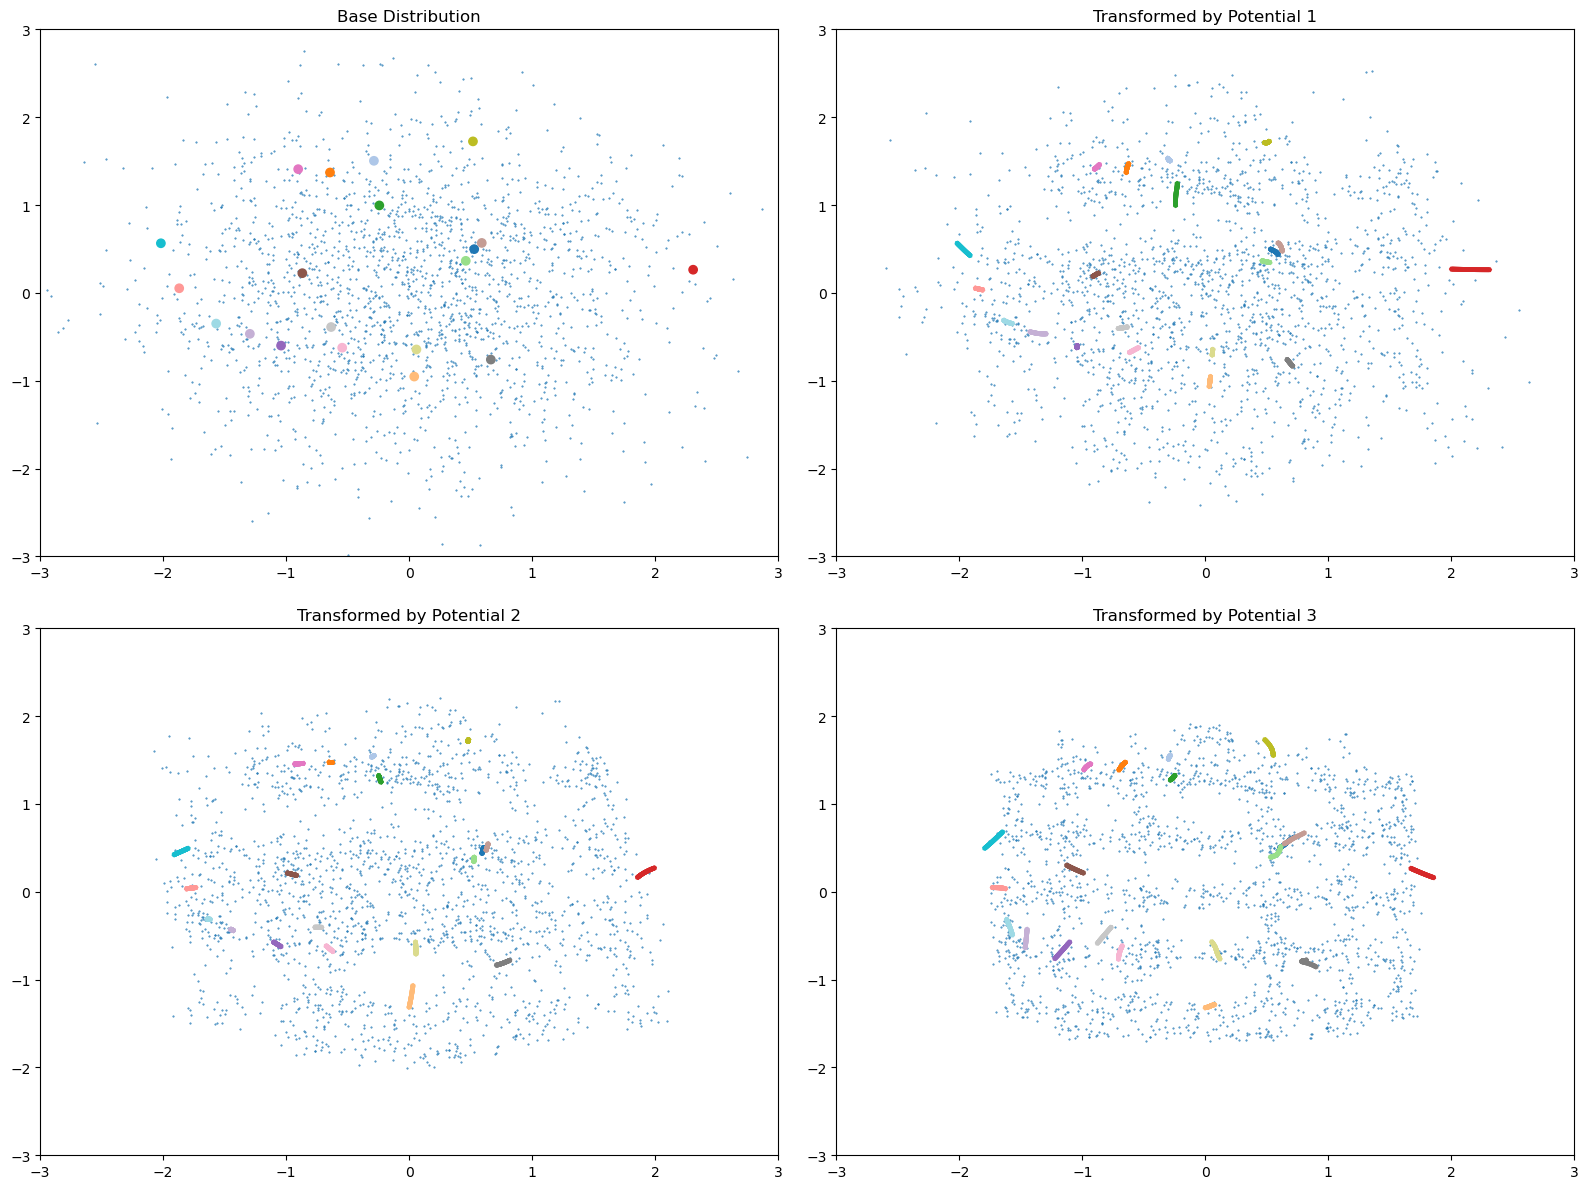

In [21]:
fig3, ax3 = plt.subplots(2,2,figsize=(16,12))
for i in range(4):
    row = i // 2
    col = i % 2
    ax3[row, col].scatter(*stepwise_sample_otf[i].T, s=0.2)

    if i > 0:
        ax3[row, col].set_title(f'Transformed by Potential {i}')
        for j_sample in range(20):
            x,y = stepwise_sample_interm_otf[i][j_sample].T
            ax3[row, col].quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], 
                                scale_units='xy',
                                angles='xy', 
                                scale=1., 
                                color=colors[j_sample])
        
ax3[0, 0].set_title(f'Base Distribution')
ax3[0, 0].scatter(*sample_colors.T, c=colors)
plt.tight_layout(h_pad=2)
plt.setp(ax3, xlim=(-3,3), ylim=(-3,3));

In [22]:
stepwise_sample_otf = MODEL.propagate_with_steps(sample.astype(jnp.float64), EVAL_SOLVER_STEPS, params=best_params_loss, intermed_y=True)
stepwise_sample_colors_otf = MODEL.propagate_with_steps(sample_colors.astype(jnp.float64), EVAL_SOLVER_STEPS, params=best_params_loss, intermed_y=True)

In [23]:
stepwise_sample_otf_stacked = jnp.hstack((stepwise_sample_otf[1:][0][:, :40, :], 
                                          stepwise_sample_otf[1:][1][:, :40, :], 
                                          stepwise_sample_otf[1:][2][:, :41, :]))

stepwise_sample_colors_otf_stacked = jnp.hstack((stepwise_sample_colors_otf[1:][0][:, :40, :], 
                                                 stepwise_sample_colors_otf[1:][1][:, :40, :], 
                                                 stepwise_sample_colors_otf[1:][2][:, :41, :]))

In [24]:
frames = len(stepwise_sample_otf_stacked[0])

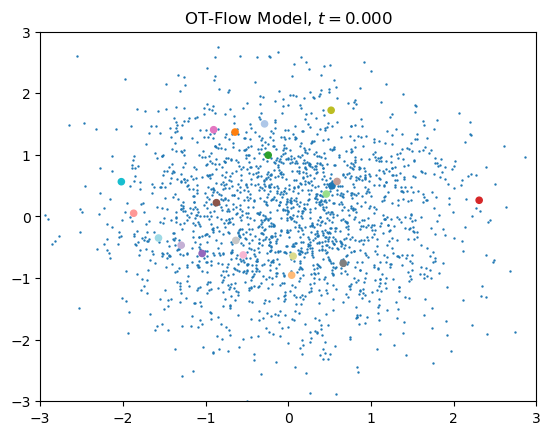

In [25]:
fig, ax = plt.subplots()

s1 = ax.scatter([], [], s=0.5)
s2 = ax.scatter(jnp.empty(20), jnp.empty(20), c=colors, s=20.)

ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
title = ax.set_title(r"OT-Flow Model, $t=0.000$")

def update(i):
    s1.set_offsets(np.column_stack([stepwise_sample_otf_stacked[:, i, 0], stepwise_sample_otf_stacked[:, i, 1]]))
    s2.set_offsets(np.column_stack([stepwise_sample_colors_otf_stacked[:, i, 0], stepwise_sample_colors_otf_stacked[:, i, 1]]))
    title.set_text(fr"OT-Flow Model, $t={i/frames:.3f}$")

ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
ani.save('otf.gif', writer='pillow')

# CNF

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from jax import config
config.update("jax_enable_x64", False)

In [3]:
import OTF, CNF, RealNVP, DatasetGenerator
import numpy as np
import pandas as pd
import optax
import matplotlib.pyplot as plt

from jax import jit, grad, value_and_grad, random
from flax.training import checkpoints

# plotting, move this to seperate notebook
from jax import vmap
import jax.numpy as jnp
from matplotlib import colormaps

2024-05-06 15:18:01.258936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
PRECISION_PREFIX = 'float32'

In [5]:
key = random.PRNGKey(seed=42)

In [6]:
training_size = 10000
validation_size = 10000
test_size = 20000

In [7]:
BATCH_SIZE_TR = training_size
BATCH_SIZE_VAL_TE = validation_size

In [8]:
train, val, test = DatasetGenerator.make_tuc_logo(
    key, 
    training_size, 
    validation_size, 
    test_size, 
    dtype=PRECISION_PREFIX,
)
normal_sample = random.normal(random.fold_in(key, 42), shape=(validation_size, 2), dtype=PRECISION_PREFIX)

In [9]:
MODEL = CNF.CNF(
    input_dim=2,
    hidden_dim=64,
    out_dim=2,
    depth=3,
    num_blocks=3,
    key=key,
    f_theta_cls=CNF.f_theta,
    exact_logp=True,     
    num_steps=20
)

LOSS_FUNC = jit(MODEL._loss)
VAL_LOSS_FUNC = jit(MODEL.metrics)
LOSS_KWARGS = {} 
VAL_LOSS_KWARGS = {'normal_batch': normal_sample}

In [10]:
EVAL_SOLVER_STEPS = 40

In [11]:
def eval_val(val_data, params, solver_steps):
    return VAL_LOSS_FUNC(params=params, batch=val_data, **VAL_LOSS_KWARGS, solver_steps=solver_steps)

In [12]:
middle = 'CNF_nol2_float32_tuc-logo_3VF'

In [13]:
params = checkpoints.restore_checkpoint('checkpoints/finalfinal/' + middle + '_params/checkpoint_20000/checkpoint', None)
best_params_loss = checkpoints.restore_checkpoint('checkpoints/finalfinal/' + middle + '_bestparams_loss/checkpoint_20000/checkpoint', None)
best_params_mmd = checkpoints.restore_checkpoint('checkpoints/finalfinal/' + middle + '.csv_bestparams_mmd/checkpoint_20000/checkpoint', None)

In [14]:
train_history = pd.read_csv('CNF_nol2_float32_tuc-logo_3VF.csv', sep=',', index_col=0)

## Plot History

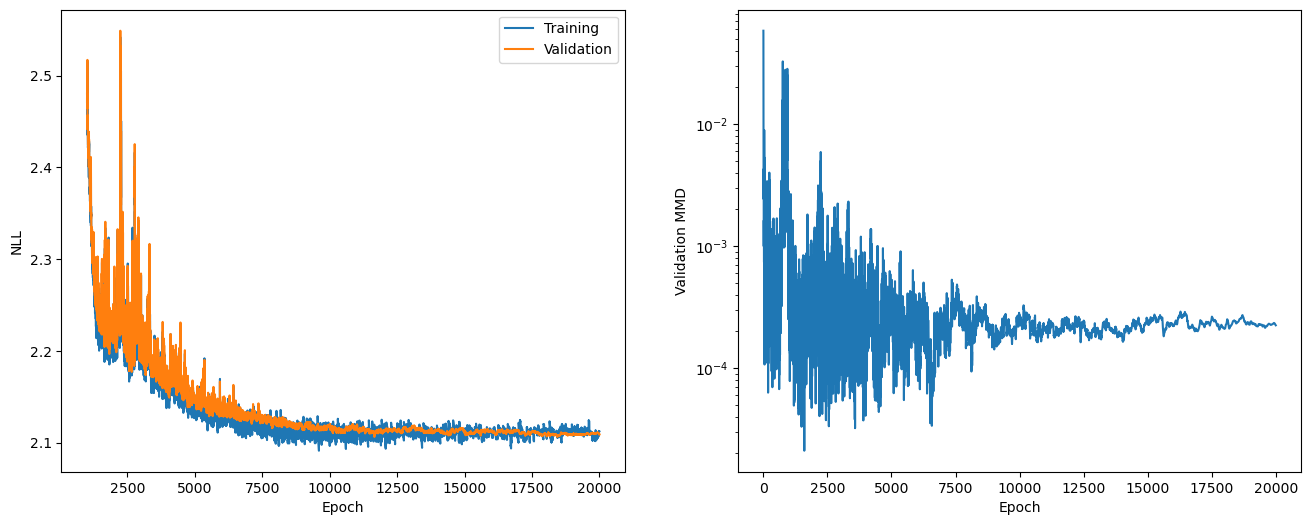

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(train_history['Epoch'][1000:], train_history['Training Loss'][1000:], label='Training')
ax[0].plot(train_history['Epoch'][1000:], train_history['Validation Loss'][1000:], label='Validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('NLL')
ax[0].legend()

ax[1].semilogy(train_history['Epoch'], train_history['Validation MMD'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation MMD');

## Test Metrics

In [16]:
best_epoch_mmd = train_history.loc[19999, 'Best Epoch MMD'].astype('int')
best_val_mmd = train_history.loc[19999, 'Best Validation MMD']

best_epoch_loss = train_history.loc[19999, 'Best Epoch Loss'].astype('int')
best_val_loss = train_history.loc[19999, 'Best Validation Loss']

In [17]:
print(f'\nBest Epoch MMD: {best_epoch_mmd} --- Val MMD: {best_val_mmd}')
test_loss, test_inv_error, test_mmd = eval_val(test, best_params_mmd, EVAL_SOLVER_STEPS)
print(f'Best Model MMD --- Test Loss: {test_loss}, Test Inv Error: {test_inv_error}, Test MMD: {test_mmd}')

print(f'\nBest Epoch Loss: {best_epoch_loss} --- Val Loss: {best_val_loss}')
test_loss, test_inv_error, test_mmd = eval_val(test, best_params_loss, EVAL_SOLVER_STEPS)
print(f'Best Model Loss --- Test Loss: {test_loss}, Test Inv Error: {test_inv_error}, Test MMD: {test_mmd}')


Best Epoch MMD: 6577 --- Val MMD: 3.5881996e-05
Best Model MMD --- Test Loss: 2.9078519344329834, Test Inv Error: 2.9904684197390452e-05, Test MMD: 0.021239936351776123

Best Epoch Loss: 11656 --- Val Loss: 2.1062577
Best Model Loss --- Test Loss: 2.146245241165161, Test Inv Error: 0.00018956117855850607, Test MMD: 7.921457290649414e-05


## Model-specific Plots

In [18]:
sample = random.normal(key, shape=(2000,2))
sample_colors = random.normal(key, shape=(20,2))

cmap = colormaps['tab20']  #('hsv') #('nipy_spectral')
max_colors = 20
colors = [cmap(color_number / max_colors) for color_number in range(max_colors)]

In [19]:
offset = 0.3
plt_params = {
    'X_MIN': np.floor(train[:, 0].min() * 10) / 10 - offset,
    'X_MAX': np.ceil(train[:, 0].max() * 10) / 10 + offset,
    'Y_MIN': np.floor(train[:, 1].min() * 10) / 10 - offset,
    'Y_MAX': np.ceil(train[:, 1].max() * 10) / 10 + offset, 
}

In [20]:
stepwise_sample_cnf = MODEL.propagate_with_steps(sample, EVAL_SOLVER_STEPS, params=best_params_loss, intermed_y=True)
stepwise_sample_colors_cnf = MODEL.propagate_with_steps(sample_colors, EVAL_SOLVER_STEPS, params=best_params_loss, intermed_y=True)

In [21]:
stepwise_sample_cnf_stacked = jnp.hstack((stepwise_sample_cnf[1:][0][:, :40, :], 
                                          stepwise_sample_cnf[1:][1][:, :40, :], 
                                          stepwise_sample_cnf[1:][2][:, :41, :]))

stepwise_sample_colors_cnf_stacked = jnp.hstack((stepwise_sample_colors_cnf[1:][0][:, :40, :], 
                                                 stepwise_sample_colors_cnf[1:][1][:, :40, :], 
                                                 stepwise_sample_colors_cnf[1:][2][:, :41, :]))

In [22]:
frames = len(stepwise_sample_cnf_stacked[0])

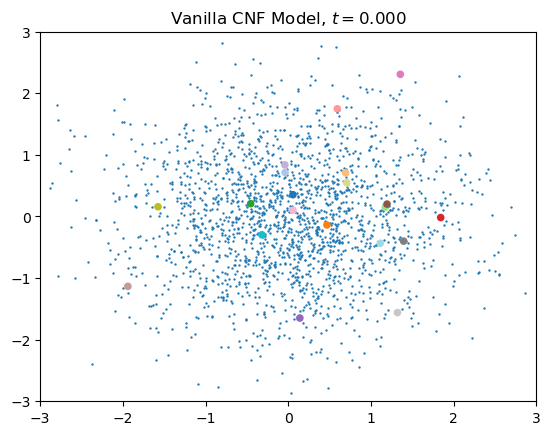

In [23]:
fig, ax = plt.subplots()

s1 = ax.scatter([], [], s=0.5)
s2 = ax.scatter(jnp.empty(20), jnp.empty(20), c=colors, s=20.)

ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
title = ax.set_title(r"Vanilla CNF Model, $t=0.000$")

def update(i):
    s1.set_offsets(np.column_stack([stepwise_sample_cnf_stacked[:, i, 0], stepwise_sample_cnf_stacked[:, i, 1]]))
    s2.set_offsets(np.column_stack([stepwise_sample_colors_cnf_stacked[:, i, 0], stepwise_sample_colors_cnf_stacked[:, i, 1]]))
    title.set_text(fr"Vanilla CNF Model, $t={i/frames:.3f}$")

ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
ani.save('cnf.gif', writer='pillow')